# Approach 2: Baseline 3dcnn with spacio temporal tensor construction

In [ ]:
# importing necessary libraries and modules
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# PHASE 1 —Data preparation (Video Frame Extraction temporal features)  

In [ ]:
class VideoDataset(Dataset):
    def __init__(self,root_dir,classes,frames_per_clip=16,transform=None):
        self.root_dir=root_dir
        self.classes=classes
        self.frames_per_clip=frames_per_clip
        self.transform=transform
        self.samples=[]
        
        # gather all video paths and assign their class labels
        for label,cls in enumerate(classes):
            class_dir=os.path.join(root_dir,cls)
            videos=[v for v in os.listdir(class_dir) if v.endswith('.mp4')]
            for v in videos:
                self.samples.append((os.path.join(class_dir,v),label))
    
    def __len__(self):
        # return number of video samples available
        return len(self.samples)
    
    def __getitem__(self,idx):
        # load a single video clip and corresponding label
        video_path,label=self.samples[idx]
        frames=self._load_frames(video_path)
        # apply frame-level transforms such as normalization
        if self.transform:
            frames=[self.transform(f) for f in frames]
        
        # convert list of frames into [C,T,H,W] tensor format
        frames=torch.stack(frames).permute(1,0,2,3)
        return frames,label
    
    def _load_frames(self,video_path):
        # read video and sample frames uniformly across its duration
        cap=cv2.VideoCapture(video_path)
        total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames=[]
        # choose sampling strategy depending on video length
        if total<self.frames_per_clip:
            frame_idxs=np.linspace(0,total-1,total,dtype=int)
        else:
            frame_idxs=np.linspace(0,total-1,self.frames_per_clip,dtype=int)
        
        for i in frame_idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES,i)
            ret,frame=cap.read()
            if not ret:
                continue  # skip failed reads safely
            # convert OpenCV BGR to RGB and resize to model resolution
            frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            frame=cv2.resize(frame,(112,112))
            frames.append(frame)
        cap.release()
        
        # if fewer frames than required repeat the last valid frame
        if len(frames)<self.frames_per_clip:
            while len(frames)<self.frames_per_clip:
                frames.append(frames[-1])
        
        return frames[:self.frames_per_clip]

# PHASE 2 — Dataset Splitting

In [ ]:
import os,random,shutil
base_dir="../data"
split_base="../data_split"
classes=["forehand","backhand","nostroke","serves"]
splits=['train','val','test']
ratios=[0.8,0.1,0.1]  # standard 80/10/10 split

# Create the folder structure for train/val/test splits
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_base,split,cls),exist_ok=True)

for cls in classes:
    src_dir=os.path.join(base_dir,cls)
    # list all videos in this class
    files=[f for f in os.listdir(src_dir) if f.endswith(".mp4")]
    random.shuffle(files)  # shuffle to ensure randomness
    n=len(files)
    n_train=int(ratios[0]*n)
    n_val=int(ratios[1]*n)

    # assign each video to train, val, or test set
    for i,file in enumerate(files):
        if i<n_train:
            dst=os.path.join(split_base,"train",cls,file)
        elif i<n_train+n_val:
            dst=os.path.join(split_base,"val",cls,file)
        else:
            dst=os.path.join(split_base,"test",cls,file)
        # copy the file into the correct split folder
        shutil.copy(os.path.join(src_dir,file),dst)

print("Dataset split complete at:",split_base)

Dataset split complete at: ../data_split


# PHASE 3 — Dataloader construction

In [ ]:
CLASSES=["forehand","backhand","nostroke","serves"]

train_dir="../data_split/train"
val_dir="../data_split/val"
test_dir="../data_split/test"

# Basic frame transforms,to convert to tensor and normalize
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.45,0.45,0.45],std=[0.225,0.225,0.225])])

# Load dataset splits using the custom video loader
train_dataset=VideoDataset(train_dir,CLASSES,transform=transform)
val_dataset=VideoDataset(val_dir,CLASSES,transform=transform)
test_dataset=VideoDataset(test_dir,CLASSES,transform=transform)

# Wrap datasets in DataLoaders for batching and iteration
train_loader=DataLoader(train_dataset,batch_size=4,shuffle=True) # shuffle for training
val_loader=DataLoader(val_dataset,batch_size=4,shuffle=False)   # no shuffle for validation
test_loader=DataLoader(test_dataset,batch_size=4,shuffle=False)  # fixed order for testing


# PHASE 3 3D CNN Model Construction

In [ ]:
class Simple3DCNN(nn.Module):
    def __init__(self,num_classes=4):
        super(Simple3DCNN,self).__init__()

        # 3D convolution blocks to learn spatiotemporal patterns
        self.features=nn.Sequential(
            nn.Conv3d(3,64,kernel_size=3,stride=1,padding=1),  # first layer captures basic motion+appearance
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1,2,2)),   # reduce spatial size, keep all frames
            nn.Conv3d(64,128,kernel_size=3,stride=1,padding=1), # deeper features for motion structure
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2,2,2)), # reduce space+time resolution slightly
            nn.Conv3d(128,256,kernel_size=3,stride=1,padding=1),# capture higher-level temporal features
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2,2,2)))   # compact representation for classifier

        # Use a dummy clip to automatically compute flattened size
        with torch.no_grad():
            dummy_input=torch.zeros(1,3,16,112,112)  # (batch,channels,frames,H,W)
            dummy_output=self.features(dummy_input)
            self.flat_features=dummy_output.view(1,-1).size(1)  # number of features after conv layers
            print(f"Flattened features: {self.flat_features}")

        # Fully connected classifier for final prediction
        self.classifier=nn.Sequential(
            nn.Linear(self.flat_features,512),   # compress learned features
            nn.ReLU(),
            nn.Dropout(0.5),    # regularization for small dataset
            nn.Linear(512,num_classes))   # output class logits

    def forward(self,x):
        # run through conv3d layers
        x=self.features(x)
        # flatten feature maps for classifier
        x=x.view(x.size(0),-1)
        # get class scores
        x=self.classifier(x)
        return x


device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=Simple3DCNN(num_classes=4).to(device)  # create and move model onto device


Flattened features: 200704


In [18]:
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=0.0001)
EPOCHS= 10

# Phase 5 Training Loop

In [ ]:
train_losses,val_losses,val_accs=[],[],[]

for epoch in range(EPOCHS):
    model.train()  # enable training mode (dropout, gradients)
    running_loss=0.0
    
    for frames,labels in tqdm(train_loader,desc=f"Epoch {epoch+1}/{EPOCHS}"):
        frames,labels=frames.to(device),labels.to(device)

        optimizer.zero_grad()   # reset gradients from previous batch
        outputs=model(frames)# forward pass through 3D CNN
        loss=criterion(outputs,labels) # compute classification loss
        loss.backward()# backpropagate gradients
        optimizer.step()    # update model parameters
        
        running_loss+=loss.item()  # accumulate training loss
    
    avg_train_loss=running_loss/len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()   # inference mode for stable evaluation
    val_loss,correct,total=0.0,0,0
    
    with torch.no_grad():   # disable gradient computation
        for frames,labels in val_loader:
            frames,labels=frames.to(device),labels.to(device)
            outputs=model(frames)   # forward pass only
            loss=criterion(outputs,labels)
            val_loss+=loss.item()
            # track correct predictions for accuracy
            _,preds=torch.max(outputs,1)
            correct+=(preds==labels).sum().item()
            total+=labels.size(0)
    
    avg_val_loss=val_loss/len(val_loader)
    val_acc=100*correct/total
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss:{avg_train_loss:.3f} | Val Loss:{avg_val_loss:.3f} | Val Acc:{val_acc:.2f}%")


Epoch 1/10:   0%|                                        | 0/20 [00:00<?, ?it/s][h264 @ 0x11f83a6b0] mmco: unref short failure
[h264 @ 0x11f83a6b0] mmco: unref short failure
[h264 @ 0x11f83a6b0] mmco: unref short failure
[h264 @ 0x11f83a6b0] mmco: unref short failure
[h264 @ 0x11f83a6b0] mmco: unref short failure
[h264 @ 0x11f83a6b0] mmco: unref short failure
[h264 @ 0x11f83a6b0] mmco: unref short failure
[h264 @ 0x11f83a6b0] mmco: unref short failure
[h264 @ 0x11fa3af10] mmco: unref short failure
[h264 @ 0x11fa3af10] mmco: unref short failure
[h264 @ 0x11fa3af10] mmco: unref short failure
[h264 @ 0x11fa3af10] mmco: unref short failure
[h264 @ 0x11fa3af10] mmco: unref short failure
[h264 @ 0x11fa3af10] mmco: unref short failure
[h264 @ 0x11fa3af10] mmco: unref short failure
[h264 @ 0x11fa3af10] mmco: unref short failure
Epoch 1/10:   5%|█▌                              | 1/20 [00:05<01:41,  5.33s/it][h264 @ 0x13b62d5c0] mmco: unref short failure
[h264 @ 0x13b62d5c0] mmco: unref short fa

Epoch [1/10] | Train Loss: 1.192 | Val Loss: 1.051 | Val Acc: 60.00%


Epoch 2/10:   0%|                                        | 0/20 [00:00<?, ?it/s][h264 @ 0x11f83ee50] mmco: unref short failure
[h264 @ 0x11f83ee50] mmco: unref short failure
[h264 @ 0x11f83ee50] mmco: unref short failure
[h264 @ 0x11f83ee50] mmco: unref short failure
[h264 @ 0x11f83ee50] mmco: unref short failure
[h264 @ 0x11f83ee50] mmco: unref short failure
[h264 @ 0x11f83ee50] mmco: unref short failure
[h264 @ 0x11f83ee50] mmco: unref short failure
Epoch 2/10:  10%|███▏                            | 2/20 [00:12<01:50,  6.12s/it][h264 @ 0x13b62f9b0] mmco: unref short failure
[h264 @ 0x13b62f9b0] mmco: unref short failure
[h264 @ 0x13b62f9b0] mmco: unref short failure
[h264 @ 0x13b62f9b0] mmco: unref short failure
[h264 @ 0x13b62f9b0] mmco: unref short failure
[h264 @ 0x13b62f9b0] mmco: unref short failure
[h264 @ 0x13b62f9b0] mmco: unref short failure
[h264 @ 0x13b62f9b0] mmco: unref short failure
Epoch 2/10:  25%|████████                        | 5/20 [00:28<01:24,  5.66s/it][h264 @ 

Epoch [2/10] | Train Loss: 0.547 | Val Loss: 0.653 | Val Acc: 70.00%


Epoch 3/10:   0%|                                        | 0/20 [00:00<?, ?it/s][h264 @ 0x11eb66100] mmco: unref short failure
[h264 @ 0x11eb66100] mmco: unref short failure
[h264 @ 0x11eb66100] mmco: unref short failure
[h264 @ 0x11eb66100] mmco: unref short failure
[h264 @ 0x11eb66100] mmco: unref short failure
[h264 @ 0x11eb66100] mmco: unref short failure
[h264 @ 0x11eb66100] mmco: unref short failure
[h264 @ 0x11eb66100] mmco: unref short failure
Epoch 3/10:  10%|███▏                            | 2/20 [00:12<01:49,  6.08s/it][h264 @ 0x10d5eff90] mmco: unref short failure
[h264 @ 0x10d5eff90] mmco: unref short failure
[h264 @ 0x10d5eff90] mmco: unref short failure
[h264 @ 0x10d5eff90] mmco: unref short failure
[h264 @ 0x10d5eff90] mmco: unref short failure
[h264 @ 0x10d5eff90] mmco: unref short failure
[h264 @ 0x10d5eff90] mmco: unref short failure
[h264 @ 0x10d5eff90] mmco: unref short failure
Epoch 3/10:  15%|████▊                           | 3/20 [00:17<01:40,  5.93s/it][h264 @ 

Epoch [3/10] | Train Loss: 0.370 | Val Loss: 0.730 | Val Acc: 60.00%


Epoch 4/10:   5%|█▌                              | 1/20 [00:06<02:04,  6.58s/it][h264 @ 0x15c030970] mmco: unref short failure
[h264 @ 0x15c030970] mmco: unref short failure
[h264 @ 0x15c030970] mmco: unref short failure
[h264 @ 0x15c030970] mmco: unref short failure
[h264 @ 0x15c030970] mmco: unref short failure
[h264 @ 0x15c030970] mmco: unref short failure
[h264 @ 0x15c030970] mmco: unref short failure
[h264 @ 0x15c030970] mmco: unref short failure
[h264 @ 0x15c030c30] mmco: unref short failure
[h264 @ 0x15c030c30] mmco: unref short failure
[h264 @ 0x15c030c30] mmco: unref short failure
[h264 @ 0x15c030c30] mmco: unref short failure
[h264 @ 0x15c030c30] mmco: unref short failure
[h264 @ 0x15c030c30] mmco: unref short failure
[h264 @ 0x15c030c30] mmco: unref short failure
[h264 @ 0x15c030c30] mmco: unref short failure
[h264 @ 0x15c031070] mmco: unref short failure
[h264 @ 0x15c031070] mmco: unref short failure
[h264 @ 0x15c031070] mmco: unref short failure
[h264 @ 0x15c031070] mmco: 

Epoch [4/10] | Train Loss: 0.248 | Val Loss: 0.550 | Val Acc: 60.00%


Epoch 5/10:   0%|                                        | 0/20 [00:00<?, ?it/s][h264 @ 0x10d5eeeb0] mmco: unref short failure
[h264 @ 0x10d5eeeb0] mmco: unref short failure
[h264 @ 0x10d5eeeb0] mmco: unref short failure
[h264 @ 0x10d5eeeb0] mmco: unref short failure
[h264 @ 0x10d5eeeb0] mmco: unref short failure
[h264 @ 0x10d5eeeb0] mmco: unref short failure
[h264 @ 0x10d5eeeb0] mmco: unref short failure
[h264 @ 0x10d5eeeb0] mmco: unref short failure
Epoch 5/10:   5%|█▌                              | 1/20 [00:05<01:44,  5.50s/it][h264 @ 0x13b62fe80] mmco: unref short failure
[h264 @ 0x13b62fe80] mmco: unref short failure
[h264 @ 0x13b62fe80] mmco: unref short failure
[h264 @ 0x13b62fe80] mmco: unref short failure
[h264 @ 0x13b62fe80] mmco: unref short failure
[h264 @ 0x13b62fe80] mmco: unref short failure
[h264 @ 0x13b62fe80] mmco: unref short failure
[h264 @ 0x13b62fe80] mmco: unref short failure
[h264 @ 0x13b630120] mmco: unref short failure
[h264 @ 0x13b630120] mmco: unref short fa

Epoch [5/10] | Train Loss: 0.162 | Val Loss: 0.525 | Val Acc: 60.00%


Epoch 6/10:   0%|                                        | 0/20 [00:00<?, ?it/s][h264 @ 0x13b62e9b0] mmco: unref short failure
[h264 @ 0x13b62e9b0] mmco: unref short failure
[h264 @ 0x13b62e9b0] mmco: unref short failure
[h264 @ 0x13b62e9b0] mmco: unref short failure
[h264 @ 0x13b62e9b0] mmco: unref short failure
[h264 @ 0x13b62e9b0] mmco: unref short failure
[h264 @ 0x13b62e9b0] mmco: unref short failure
[h264 @ 0x13b62e9b0] mmco: unref short failure
Epoch 6/10:  15%|████▊                           | 3/20 [00:18<01:48,  6.37s/it][h264 @ 0x15c034420] mmco: unref short failure
[h264 @ 0x15c034420] mmco: unref short failure
[h264 @ 0x15c034420] mmco: unref short failure
[h264 @ 0x15c034420] mmco: unref short failure
[h264 @ 0x15c034420] mmco: unref short failure
[h264 @ 0x15c034420] mmco: unref short failure
[h264 @ 0x15c034420] mmco: unref short failure
[h264 @ 0x15c034420] mmco: unref short failure
[h264 @ 0x13b62e880] mmco: unref short failure
[h264 @ 0x13b62e880] mmco: unref short fa

Epoch [6/10] | Train Loss: 0.151 | Val Loss: 0.441 | Val Acc: 70.00%


Epoch 7/10:   0%|                                        | 0/20 [00:00<?, ?it/s][h264 @ 0x13b62ea80] mmco: unref short failure
[h264 @ 0x13b62ea80] mmco: unref short failure
[h264 @ 0x13b62ea80] mmco: unref short failure
[h264 @ 0x13b62ea80] mmco: unref short failure
[h264 @ 0x13b62ea80] mmco: unref short failure
[h264 @ 0x13b62ea80] mmco: unref short failure
[h264 @ 0x13b62ea80] mmco: unref short failure
[h264 @ 0x13b62ea80] mmco: unref short failure
Epoch 7/10:   5%|█▌                              | 1/20 [00:05<01:47,  5.65s/it][h264 @ 0x13b630000] mmco: unref short failure
[h264 @ 0x13b630000] mmco: unref short failure
[h264 @ 0x13b630000] mmco: unref short failure
[h264 @ 0x13b630000] mmco: unref short failure
[h264 @ 0x13b630000] mmco: unref short failure
[h264 @ 0x13b630000] mmco: unref short failure
[h264 @ 0x13b630000] mmco: unref short failure
[h264 @ 0x13b630000] mmco: unref short failure
[h264 @ 0x10d5eda30] mmco: unref short failure
[h264 @ 0x10d5eda30] mmco: unref short fa

Epoch [7/10] | Train Loss: 0.145 | Val Loss: 0.459 | Val Acc: 60.00%


Epoch 8/10:  10%|███▏                            | 2/20 [00:12<01:51,  6.22s/it][h264 @ 0x10d5f0780] mmco: unref short failure
[h264 @ 0x10d5f0780] mmco: unref short failure
[h264 @ 0x10d5f0780] mmco: unref short failure
[h264 @ 0x10d5f0780] mmco: unref short failure
[h264 @ 0x10d5f0780] mmco: unref short failure
[h264 @ 0x10d5f0780] mmco: unref short failure
[h264 @ 0x10d5f0780] mmco: unref short failure
[h264 @ 0x10d5f0780] mmco: unref short failure
Epoch 8/10:  15%|████▊                           | 3/20 [00:17<01:38,  5.81s/it][h264 @ 0x10d5ef5b0] mmco: unref short failure
[h264 @ 0x10d5ef5b0] mmco: unref short failure
[h264 @ 0x10d5ef5b0] mmco: unref short failure
[h264 @ 0x10d5ef5b0] mmco: unref short failure
[h264 @ 0x10d5ef5b0] mmco: unref short failure
[h264 @ 0x10d5ef5b0] mmco: unref short failure
[h264 @ 0x10d5ef5b0] mmco: unref short failure
[h264 @ 0x10d5ef5b0] mmco: unref short failure
Epoch 8/10:  25%|████████                        | 5/20 [00:30<01:29,  5.98s/it][h264 @ 

Epoch [8/10] | Train Loss: 0.161 | Val Loss: 0.469 | Val Acc: 60.00%


Epoch 9/10:  10%|███▏                            | 2/20 [00:11<01:44,  5.79s/it][h264 @ 0x10d5ef690] mmco: unref short failure
[h264 @ 0x10d5ef690] mmco: unref short failure
[h264 @ 0x10d5ef690] mmco: unref short failure
[h264 @ 0x10d5ef690] mmco: unref short failure
[h264 @ 0x10d5ef690] mmco: unref short failure
[h264 @ 0x10d5ef690] mmco: unref short failure
[h264 @ 0x10d5ef690] mmco: unref short failure
[h264 @ 0x10d5ef690] mmco: unref short failure
Epoch 9/10:  20%|██████▍                         | 4/20 [00:24<01:39,  6.20s/it][h264 @ 0x15c032790] mmco: unref short failure
[h264 @ 0x15c032790] mmco: unref short failure
[h264 @ 0x15c032790] mmco: unref short failure
[h264 @ 0x15c032790] mmco: unref short failure
[h264 @ 0x15c032790] mmco: unref short failure
[h264 @ 0x15c032790] mmco: unref short failure
[h264 @ 0x15c032790] mmco: unref short failure
[h264 @ 0x15c032790] mmco: unref short failure
Epoch 9/10:  25%|████████                        | 5/20 [00:30<01:33,  6.26s/it][h264 @ 

Epoch [9/10] | Train Loss: 0.067 | Val Loss: 0.883 | Val Acc: 70.00%


Epoch 10/10:   0%|                                       | 0/20 [00:00<?, ?it/s][h264 @ 0x13b630d90] mmco: unref short failure
[h264 @ 0x13b630d90] mmco: unref short failure
[h264 @ 0x13b630d90] mmco: unref short failure
[h264 @ 0x13b630d90] mmco: unref short failure
[h264 @ 0x13b630d90] mmco: unref short failure
[h264 @ 0x13b630d90] mmco: unref short failure
[h264 @ 0x13b630d90] mmco: unref short failure
[h264 @ 0x13b630d90] mmco: unref short failure
Epoch 10/10:   5%|█▌                             | 1/20 [00:05<01:52,  5.92s/it][h264 @ 0x13b629db0] mmco: unref short failure
[h264 @ 0x13b629db0] mmco: unref short failure
[h264 @ 0x13b629db0] mmco: unref short failure
[h264 @ 0x13b629db0] mmco: unref short failure
[h264 @ 0x13b629db0] mmco: unref short failure
[h264 @ 0x13b629db0] mmco: unref short failure
[h264 @ 0x13b629db0] mmco: unref short failure
[h264 @ 0x13b629db0] mmco: unref short failure
Epoch 10/10:  20%|██████▏                        | 4/20 [00:24<01:40,  6.27s/it][h264 @ 

Epoch [10/10] | Train Loss: 0.135 | Val Loss: 0.546 | Val Acc: 80.00%


# Phase 6 Model testing

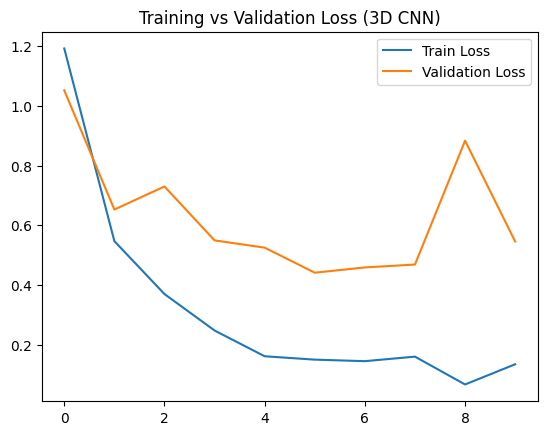

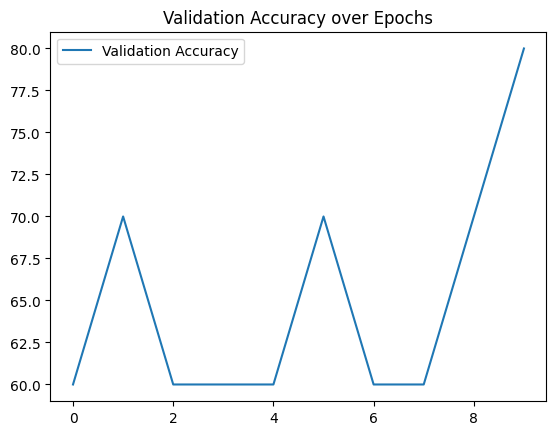

In [ ]:
# training and validation loss to visualize learning progress
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Training vs Validation Loss (3D CNN)")
plt.show()

# validation accuracy to track generalization performance
plt.figure()
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.title("Validation Accuracy over Epochs")
plt.show()

In [ ]:
model.eval() #model evaluation to find the test accuracy
correct, total = 0, 0
with torch.no_grad():
    for frames, labels in test_loader:
        frames, labels = frames.to(device), labels.to(device)
        outputs = model(frames)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
print(f"Test Accuracy: {100 * correct / total:.2f}%") 

[h264 @ 0x14b72a110] mmco: unref short failure
[h264 @ 0x14b72a110] mmco: unref short failure
[h264 @ 0x14b72a110] mmco: unref short failure
[h264 @ 0x14b72a110] mmco: unref short failure
[h264 @ 0x14b72a110] mmco: unref short failure
[h264 @ 0x14b72a110] mmco: unref short failure
[h264 @ 0x14b72a110] mmco: unref short failure
[h264 @ 0x14b72a110] mmco: unref short failure
[h264 @ 0x13b72f750] mmco: unref short failure
[h264 @ 0x13b72f750] mmco: unref short failure
[h264 @ 0x13b72f750] mmco: unref short failure
[h264 @ 0x13b72f750] mmco: unref short failure
[h264 @ 0x13b72f750] mmco: unref short failure
[h264 @ 0x13b72f750] mmco: unref short failure
[h264 @ 0x13b72f750] mmco: unref short failure
[h264 @ 0x13b72f750] mmco: unref short failure


Test Accuracy: 80.00%


In [ ]:
torch.save(model.state_dict(), "../models/3dcnn_model.pt") # saving the best model
print("3D CNN Model saved")

3D CNN Model saved
